In [1]:
import os
import numpy as np
import pandas as pd
import ray
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from statsmodels.tools import add_constant
from sklearn.metrics import mean_squared_error

from utils.ols_utils import construct_interactions, write_train_test, run_rf, run_ate, pad_betas
from utils.sc_utils import run_series, run_series_random

os.makedirs('data/tmp', exist_ok=True)

# Read in the data

### OLS - LaLonde

In [2]:
!wget -O data/nswre74_controls.txt http://www.nber.org/~rdehejia/data/nswre74_control.txt
!wget -O data/cps_controls.txt http://www.nber.org/~rdehejia/data/cps_controls.txt

URL transformed to HTTPS due to an HSTS policy
--2023-10-12 11:18:49--  https://www.nber.org/~rdehejia/data/nswre74_control.txt
Resolving www.nber.org (www.nber.org)... 23.185.0.2, 2620:12a:8000::2, 2620:12a:8001::2
Connecting to www.nber.org (www.nber.org)|23.185.0.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.nber.org/~rdehejia/data/nswre74_control.txt [following]
--2023-10-12 11:18:49--  https://users.nber.org/~rdehejia/data/nswre74_control.txt
Resolving users.nber.org (users.nber.org)... 198.71.6.39, 198.71.6.22
Connecting to users.nber.org (users.nber.org)|198.71.6.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41860 (41K) [text/plain]
Saving to: ‘data/nswre74_controls.txt’

data/nswre74_contro 100%[===================>]  40.88K  --.-KB/s    in 0.1s    

2023-10-12 11:18:50 (296 KB/s) - ‘data/nswre74_controls.txt’ saved [41860/41860]

URL transformed to HTTPS due to an HSTS policy
--2023-10-

In [3]:
def read_lalonde(file):
    df = pd.read_csv(
        file, 
        sep=' ', 
        header=None,
    ).dropna(how='all', axis=1)

    df.columns = ['t', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75', 're78']
    
    for col in df.columns:
        if not col.startswith('re'): 
            df[col] = df[col].astype(int)
        
    return df

In [4]:
re74_control = read_lalonde('data/nswre74_controls.txt')
cps_control = read_lalonde('data/cps_controls.txt')

## convert values to be in 1000s of $
for col in ['re74', 're75', 're78']:
    for x in [cps_control, re74_control]:
        x[col] = x[col] / 1000

re74_control['test'] = 1
cps_control['test'] = 0

lalonde = pd.concat([cps_control, re74_control])

# construct the interaction terms
lalonde_mat = construct_interactions(lalonde)

Using 69 quantiles to achieve 50 bins for re74
Using 70 quantiles to achieve 50 bins for re75


In [5]:
# write out the train/test datasets, using NSW experimental controls as test set

# remove all interaction columns that are constant everywhere
const_cols = list((lalonde_mat.std()[lalonde_mat.std() == 0]).index)

write_train_test(
    df=lalonde_mat.drop(columns=const_cols),
    benchmark_df=lalonde,
    n_train=3000,
    noisy=True,
    exptest=True,
    outname='data/tmp/cps_noisy_3k_exptest_noconst'
)

# Train: 3000
# Test: 260


In [6]:
# write down a set where the out-of-sample is the same as in-sample, to allow for in-sample error analysis
X_train = np.load('data/tmp/cps_noisy_3k_exptest_noconst_features.npz')['train']
y_train = np.load('data/tmp/cps_noisy_3k_exptest_noconst_label.npz')['train']
np.savez_compressed(
    'data/tmp/cps_noisy_3k_exptest_noconst_features_insample.npz', 
    train=X_train, 
    test=X_train
)

np.savez_compressed(
    'data/tmp/cps_noisy_3k_exptest_noconst_label_insample.npz', 
    train=y_train, 
    test=y_train
)

### Synthetic Controls - Smoking

In [7]:
smoking = pd.read_csv(
    'data/The_Tax_Burden_on_Tobacco__1970-2019.csv'
)

pc_smoking = smoking.loc[
    (smoking['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)') &
    (smoking['Year'] <= 1989)
][['LocationAbbr', 'Year', 'Data_Value']].rename({"LocationAbbr": "state", "Year": 'year', "Data_Value": 'daily_packs'}, axis=1).sort_values(['year', 'state']).copy()

# Run the models

In [8]:
## initialize ray for parallelization - set num_cpus equal to desired number of cores
## following cells take ~1hr to run with num_cpus = 48
ray.shutdown()
ray.init(num_cpus=48)

{'node_ip_address': '171.67.96.196',
 'raylet_ip_address': '171.67.96.196',
 'redis_address': '171.67.96.196:6379',
 'object_store_address': '/tmp/ray/session_2023-10-12_11-19-26_269720_1146011/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2023-10-12_11-19-26_269720_1146011/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2023-10-12_11-19-26_269720_1146011',
 'metrics_export_port': 63080,
 'gcs_address': '171.67.96.196:42681',
 'node_id': '6d492a3845cc409358f47941a4c8f5f308d608cb198479d95b981e49'}

## OLS - LaLonde

In [9]:
train_X = np.load('data/tmp/cps_noisy_3k_exptest_noconst_features.npz')['train']
train_y = np.load('data/tmp/cps_noisy_3k_exptest_noconst_label.npz')['train']

rmses = []
for seed in tqdm(range(5)):
    test_nest = run_rf(
        X_file=f'data/tmp/cps_noisy_3k_exptest_noconst_features.npz',
        y_file=f'data/tmp/cps_noisy_3k_exptest_noconst_label.npz',
        k_step=50,
        nest=True,
        plot=False,
        verbose=False,
        seed=seed,
        intercept=True,
        ret_beta=True,
        ret_cols=True
    )
    
    col_idxs = test_nest[-1]
    betas = test_nest[-2]

    padded_betas = pad_betas(betas, col_idxs, max(test_nest[2]))

    is_preds = padded_betas @ add_constant(train_X[:, col_idxs[-1]]).T   ## take product with correctly ordered columns
    
    is_rmses = [np.sqrt(mean_squared_error(pred, train_y)) for pred in is_preds]

    rmses.append(pd.DataFrame({"k": test_nest[2], "oos_rmse": test_nest[0], "is_rmse": is_rmses}))

avg_rmse = pd.concat(rmses).groupby('k').mean().reset_index().copy()

100%|██████████| 5/5 [20:13<00:00, 242.66s/it]


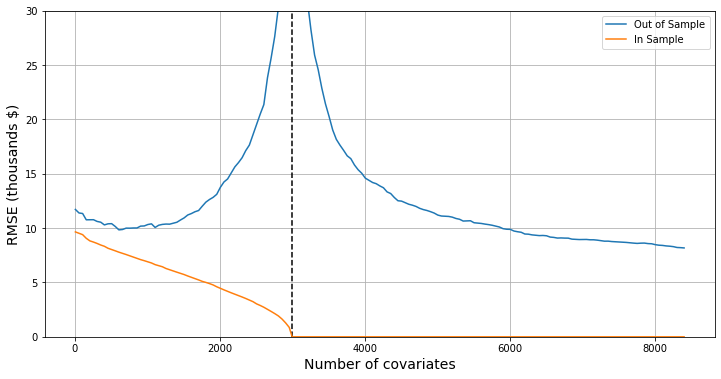

In [10]:
fig, ax = plt.subplots(figsize=(12,6))

ax.axvline(3000, color="black", linestyle="dashed")

avg_rmse[['k', 'oos_rmse', 'is_rmse']].rename({
    'oos_rmse': 'Out of Sample',
    'is_rmse': 'In Sample',
}, axis=1).set_index('k').plot(ax=ax, ylim=(0,30))

ax.set_xlabel('Number of covariates', fontsize=14)
ax.set_ylabel('RMSE (thousands $)', fontsize=14)

ax.grid()

In [11]:
avg_ate_errs, benchmark_ate_errs, beta_norm_dict = run_ate(
    X_file='data/tmp/cps_noisy_3k_exptest_noconst_features.npz', 
    y_file='data/tmp/cps_noisy_3k_exptest_noconst_label.npz', 
)

100%|██████████| 5/5 [20:56<00:00, 251.25s/it]


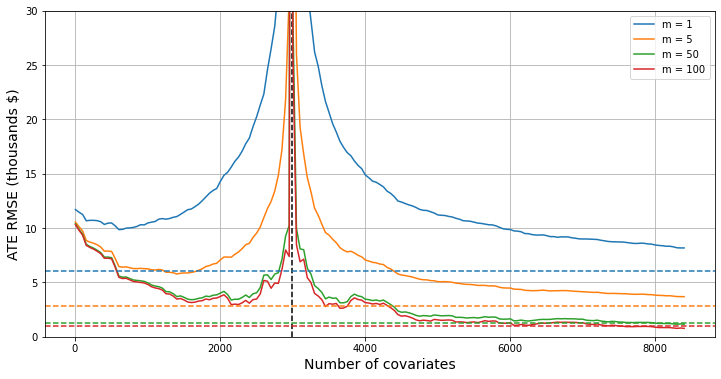

In [12]:
fig, ax = plt.subplots(figsize=(12,6))

ax.axvline(3000, color="black", linestyle="dashed")

avg_ate_errs[['k', 'n_1', 'n_5', 'n_50', 'n_100']].rename({
    'n_1': 'm = 1',
    'n_5': 'm = 5',
    'n_50': 'm = 50',
    'n_100': 'm = 100',
}, axis=1).set_index('k').plot(ax=ax, ylim=(0,30))

ax.axhline(benchmark_ate_errs[1], color="C0", linestyle="dashed")
ax.axhline(benchmark_ate_errs[5], color="C1", linestyle="dashed")
ax.axhline(benchmark_ate_errs[50], color="C2", linestyle="dashed")
ax.axhline(benchmark_ate_errs[100], color="C3", linestyle="dashed")

ax.set_xlabel('Number of covariates', fontsize=14)
ax.set_ylabel('ATE RMSE (thousands $)', fontsize=14)

ax.grid()

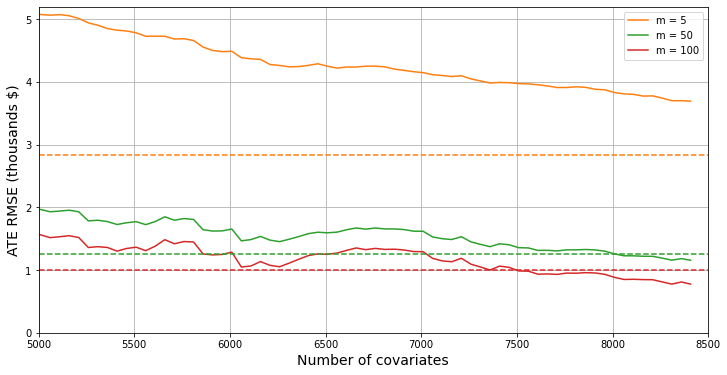

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

ax.axvline(3000, color="black", linestyle="dashed")

avg_ate_errs[['k', 'n_5', 'n_50', 'n_100']].rename({
    'n_5': 'm = 5',
    'n_50': 'm = 50',
    'n_100': 'm = 100',
}, axis=1).set_index('k').plot(ax=ax, color=['C1', 'C2', 'C3'], xlim=(5000,8500), ylim=(0,5.2))

ax.axhline(benchmark_ate_errs[5], color="C1", linestyle="dashed")
ax.axhline(benchmark_ate_errs[50], color="C2", linestyle="dashed")
ax.axhline(benchmark_ate_errs[100], color="C3", linestyle="dashed")

ax.set_xlabel('Number of covariates', fontsize=14)
ax.set_ylabel('ATE RMSE (thousands $)', fontsize=14)

ax.grid()

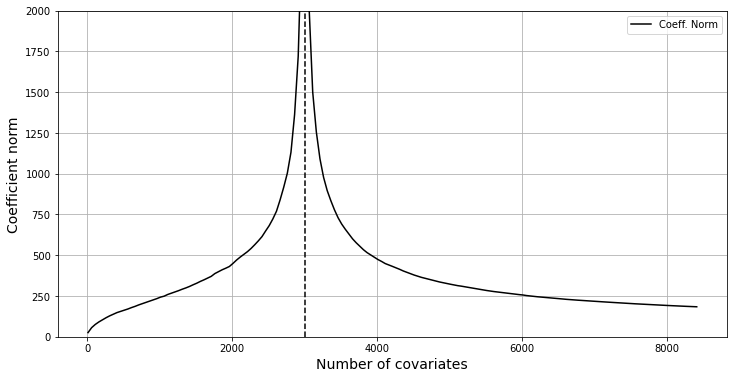

In [14]:
fig, ax = plt.subplots(figsize=(12,6))

ax.axvline(3000, color="black", linestyle="dashed")

norm_df = pd.DataFrame({
    'k': avg_ate_errs['k'].values, 
    'Coeff. Norm': np.stack(list(beta_norm_dict.values())).mean(axis=0)
})

norm_df.set_index('k').plot(ax=ax, color='black', ylim=(0,2000))

ax.set_xlabel('Number of covariates', fontsize=14)
ax.set_ylabel('Coefficient norm', fontsize=14)

ax.grid()

### Synthetic Control - Smoking

In [15]:
res20_CA = run_series(df=pc_smoking, num_states=20, target_state='CA')

# get the average in-sample and out-of-sample RMSEs across all combinations
stats = res20_CA.groupby('n')[['err_is', 'err_oos']].mean().reset_index()

100%|██████████| 20/20 [08:02<00:00, 24.14s/it]


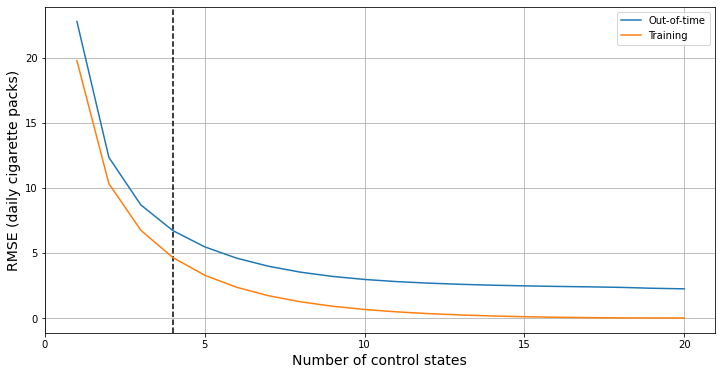

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

ax.axvline(4, color="black", linestyle="dashed")

stats.rename({'err_is': 'Training', 'err_oos': 'Out-of-time'}, axis=1).set_index('n')[['Out-of-time', 'Training']].plot(ax=ax)

ax.set_xlabel('Number of control states', fontsize=14)
ax.set_ylabel('RMSE (daily cigarette packs)', fontsize=14)

ax.grid()

ax.set_xticks([0,5,10,15,20])

In [17]:
full_res = run_series_random(
    df=pc_smoking,
    num_states=50,
    num_samples=int(1e4),
    num_lags=10,
    gap=2,
    target_state='CA'
)

100%|██████████| 50/50 [07:08<00:00,  8.57s/it]


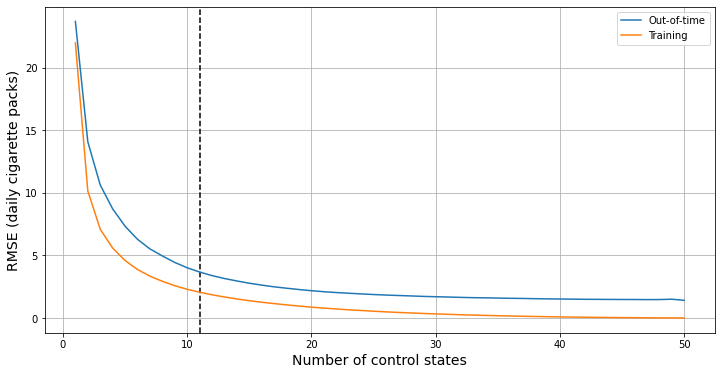

In [18]:
fig, ax = plt.subplots(figsize=(12,6))

ax.axvline(11, color="black", linestyle="dashed")

full_res.groupby('n')[['err_is', 'err_oos']].mean().rename({"err_is": 'Training', 'err_oos': 'Out-of-time'}, axis=1)[['Out-of-time', 'Training']].plot(ax=ax)

ax.set_xlabel('Number of control states', fontsize=14)
ax.set_ylabel('RMSE (daily cigarette packs)', fontsize=14)

ax.grid()

In [19]:
ray.shutdown()